Divvy Bike data

In [1]:
import requests
import pandas as pd
import os
import re

from bs4 import BeautifulSoup
import zipfile
from datetime import datetime, timedelta

import geopandas as gpd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import contextily as ctx

import warnings
# Ignore warning messages
warnings.filterwarnings('ignore')

In [2]:
# Download historical trip data (last 15 months) for bike share in the Chicago area from Divvy

# Define the URL where the data is located and the directory where the file is to be saved
url = "https://divvy-tripdata.s3.amazonaws.com/"
directory = "raw data/Divvy Bikes/"
os.makedirs(directory, exist_ok=True)

# Check if the dataflow changed
change = False

# Obtain the page content via a GET request and parse the HTML content using BeautifulSoup.
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

# Find all the 'key' elements and extract their text, filtering out links starting with '20'. Reverse sort and select the top 15 (last 15 months) files.
links = [link.text for link in soup.find_all('key') if link.text.startswith('20')]
links = sorted(links, reverse=True)[:15]


# Iterate over each file name in the links list
for file_name in links:
    # Check if the file already exists in the directory
    if os.path.exists(os.path.join(directory, file_name)):
        print(f'{file_name} already exists')
        continue

    # Send a GET request to the URL + file_name to download the file
    response = requests.get(url + file_name)

    # Write the content of the response to a file with the same name as the downloaded file
    with open(os.path.join(directory, file_name), 'wb') as file:
        file.write(response.content)

    # Extract the contents of the zip file
    with zipfile.ZipFile(os.path.join(directory, file_name), 'r') as zip_ref:
        zip_ref.extractall(directory)

    # Print a message indicating that the file was downloaded and extracted
    print(f'{file_name} downloaded and extracted')
    change = True

202403-divvy-tripdata.zip downloaded and extracted
202402-divvy-tripdata.zip already exists
202401-divvy-tripdata.zip already exists
202312-divvy-tripdata.zip already exists
202311-divvy-tripdata.zip already exists
202310-divvy-tripdata.zip already exists
202309-divvy-tripdata.zip already exists
202308-divvy-tripdata.zip already exists
202307-divvy-tripdata.zip already exists
202306-divvy-tripdata.zip already exists
202305-divvy-tripdata.zip already exists
202304-divvy-tripdata.zip already exists
202303-divvy-tripdata.zip already exists
202302-divvy-tripdata.zip already exists
202301-divvy-tripdata.zip already exists


In [3]:
# For the first run, the data variable is not yet defined, creating an empty DataFrame
if 'bike_raw' not in globals():
    bike_raw = pd.DataFrame()

#
csv_files = [filecsv for filecsv in os.listdir(directory) if filecsv.endswith('.csv')]

df_chunks = []

# 检查DataFrame是否为空
if not bike_raw.empty:
    unique_refs = bike_raw['REF'].unique()
else:
    unique_refs = []

for filecsv in csv_files:
    file_prefix = filecsv[:6]
    print(file_prefix)
    if file_prefix not in unique_refs:
        print(f'Adding {filecsv} to the DataFrame')
        df_chunk = pd.read_csv(os.path.join(directory, filecsv))
        df_chunk['REF'] = file_prefix
        df_chunks.append(df_chunk)
    else:
        print(f'{filecsv} already exists in the DataFrame')

if df_chunks:
    df = pd.concat(df_chunks)
else:
    df = pd.DataFrame() 

bike_raw = pd.concat([bike_raw, df])

bike_raw['REF'] = bike_raw['REF'].astype(str)
bike_raw['REF'].unique()

202301
Adding 202301-divvy-tripdata.csv to the DataFrame
202302
Adding 202302-divvy-tripdata.csv to the DataFrame
202303
Adding 202303-divvy-tripdata.csv to the DataFrame
202304
Adding 202304-divvy-tripdata.csv to the DataFrame
202305
Adding 202305-divvy-tripdata.csv to the DataFrame
202306
Adding 202306-divvy-tripdata.csv to the DataFrame
202307
Adding 202307-divvy-tripdata.csv to the DataFrame
202308
Adding 202308-divvy-tripdata.csv to the DataFrame
202309
Adding 202309-divvy-tripdata.csv to the DataFrame
202310
Adding 202310-divvy-tripdata.csv to the DataFrame
202311
Adding 202311-divvy-tripdata.csv to the DataFrame
202312
Adding 202312-divvy-tripdata.csv to the DataFrame
202401
Adding 202401-divvy-tripdata.csv to the DataFrame
202402
Adding 202402-divvy-tripdata.csv to the DataFrame
202403
Adding 202403-divvy-tripdata.csv to the DataFrame


array(['202301', '202302', '202303', '202304', '202305', '202306',
       '202307', '202308', '202309', '202310', '202311', '202312',
       '202401', '202402', '202403'], dtype=object)

In [4]:
print(bike_raw.shape)
bike_raw

(6389601, 14)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,REF
0,F96D5A74A3E41399,electric_bike,2023-01-21 20:05:42,2023-01-21 20:16:33,Lincoln Ave & Fullerton Ave,TA1309000058,Hampden Ct & Diversey Ave,202480.0,41.924074,-87.646278,41.930000,-87.640000,member,202301
1,13CB7EB698CEDB88,classic_bike,2023-01-10 15:37:36,2023-01-10 15:46:05,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,202301
2,BD88A2E670661CE5,electric_bike,2023-01-02 07:51:57,2023-01-02 08:05:11,Western Ave & Lunt Ave,RP-005,Valli Produce - Evanston Plaza,599,42.008571,-87.690483,42.039742,-87.699413,casual,202301
3,C90792D034FED968,classic_bike,2023-01-22 10:52:58,2023-01-22 11:01:44,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,202301
4,3397017529188E8A,classic_bike,2023-01-12 13:58:01,2023-01-12 14:13:20,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,202301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301682,C81758223C5CA8DC,electric_bike,2024-03-07 11:31:33,2024-03-07 11:49:14,South Shore Dr & 67th St,KA1503000029,Kimbark Ave & 53rd St,TA1309000037,41.773655,-87.567433,41.799568,-87.594747,member,202403
301683,C5BBE9C102CFBC49,electric_bike,2024-03-24 11:45:22,2024-03-24 11:52:08,Orleans St & Merchandise Mart Plaza,TA1305000022,State St & Chicago Ave,21544,41.887960,-87.636739,41.896617,-87.628579,member,202403
301684,E1CA6FB263B2F7DE,electric_bike,2024-03-12 17:49:30,2024-03-12 17:56:38,Wells St & Elm St,KA1504000135,Lincoln Park Conservatory,LP-,41.903144,-87.634371,41.923931,-87.635825,member,202403
301685,89D68BFC374DB04B,electric_bike,2024-03-24 18:08:56,2024-03-24 18:33:58,South Shore Dr & 67th St,KA1503000029,Kimbark Ave & 53rd St,TA1309000037,41.773643,-87.567452,41.799568,-87.594747,member,202403


In [5]:
# Define the file path to be saved
csv_file_path = 'raw data/bike_raw.csv'

# Save as CSV file
bike_raw.to_csv(csv_file_path, index=False)

print(f"bike_raw has been successfully saved to {csv_file_path}")

bike_raw has been successfully saved to raw data/bike_raw.csv


Public transport stations and city boundary

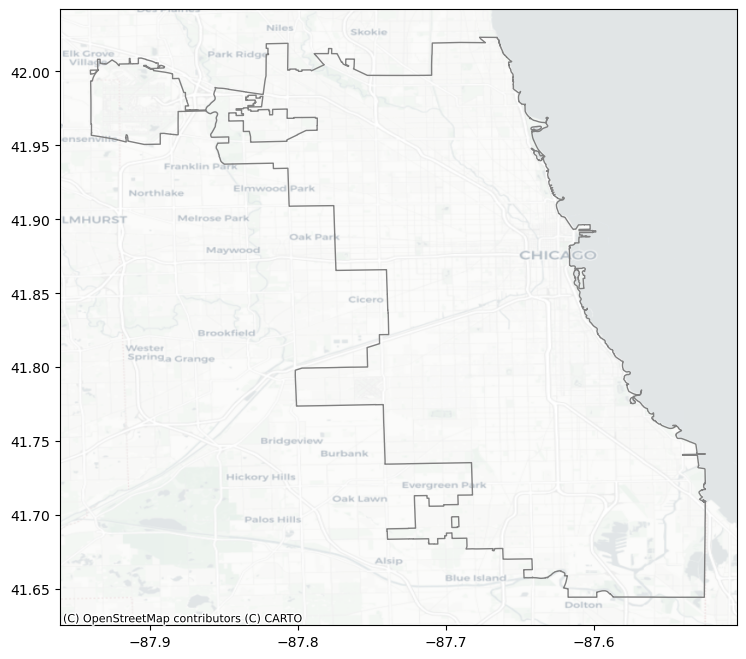

In [6]:
#city boundary
chicago=gpd.read_file('raw data/Chicago_CityBoundary/geo_export_9364be01-19fc-4f28-8f1f-64a1c42e8a42.shp')
chicago = chicago.to_crs(epsg =4326)

fig, ax = plt.subplots(figsize=(12,8))
chicago.plot(ax=ax,edgecolor='gray', linewidth=1, facecolor='none')
# Add basemap
ctx.add_basemap(ax,crs="EPSG:4326", source=ctx.providers.CartoDB.Positron, alpha=0.7)

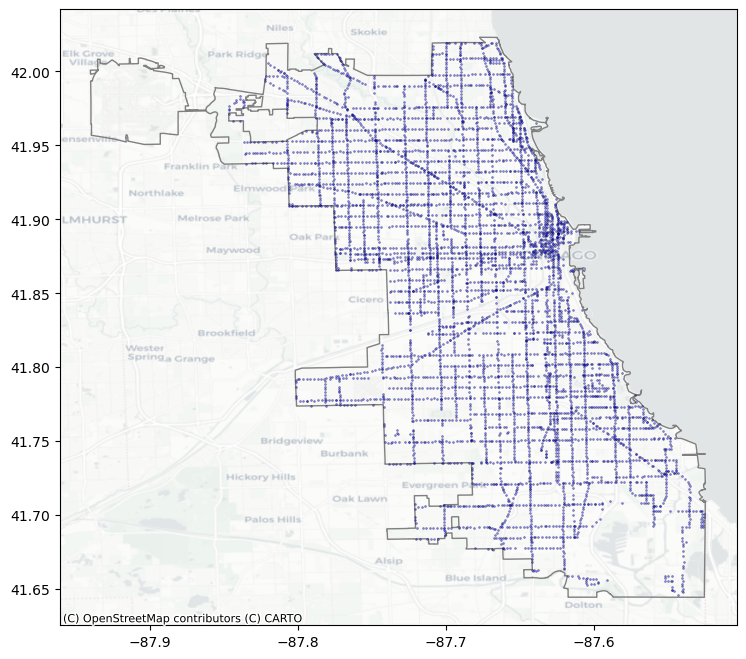

In [7]:
#Bus stops
Bus_stop = pd.read_csv("raw data/Public transport station/2023_CTA_Bus_Stops.csv")
BusStop_drop = Bus_stop.drop_duplicates(subset=['STREET', 'CROSS_ST'])

# rename columns
BusStop_filtered = BusStop_drop[['PUBLIC_NAM', 'X', 'Y']].rename(columns={'PUBLIC_NAM': 'Station_name', 'X': 'longitude', 'Y': 'latitude'})

#inner
BusStop_filtered_gdf = gpd.GeoDataFrame(
    BusStop_filtered, geometry=gpd.points_from_xy(BusStop_filtered['longitude'], BusStop_filtered['latitude']))
BusStop_filtered_gdf.set_crs(epsg=4326, inplace=True)
BusStop_inner = gpd.clip(BusStop_filtered_gdf, chicago)

# Add type column
BusStop_inner['type'] = 'Bus stop'
# Sort by longitude and latitude.
BusStop_unique = BusStop_inner.sort_values(by=['longitude', 'latitude']) 
BusStop_unique.reset_index(drop=True, inplace=True)

#save
BusStop_unique.to_csv('raw data/BusStop_unique.csv', index=False)


#Station Distribution Map
fig, ax = plt.subplots(figsize=(12,8))
chicago.plot(ax=ax, edgecolor='gray', linewidth=1, facecolor='none')
BusStop_unique.plot(ax=ax,
                    markersize=2, color='blue', alpha=0.5,
                    edgecolor='black', linewidth=0.3)
# Add basemap
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron, alpha=0.7)

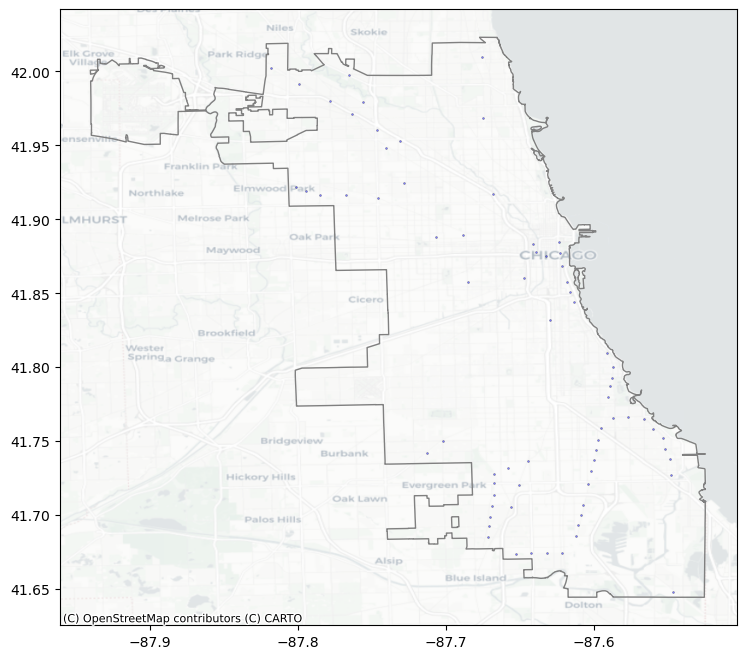

In [8]:
#Metro station
Metra_Rail_Stations = gpd.read_file("raw data/Public transport station/2023_Metra_Rail_Stations.geojson")
Metra_Rail_Stations.to_csv("raw data/Public transport station/2023_Metra_Rail_Stations.csv", index=False)

MetroStation = pd.read_csv("raw data/Public transport station/2023_Metra_Rail_Stations.csv")
MetroStation_filtered = MetroStation[['SHORTNAME', 'geometry']].rename(columns={'SHORTNAME': 'Station_name'})

# Define a regular expression to match the coordinate
pattern = r'MULTIPOINT\s*\(\s*([-\d.]+)\s+([-\d.]+)'

def extract_coords(text):
    match = re.match(pattern, text)
    if match:
        return match.groups()
    else:
        return None, None
    
# Use regular expressions to extract coordinates and handle possible mismatches
MetroStation_filtered['longitude'], MetroStation_filtered['latitude'] = zip(*MetroStation_filtered['geometry'].apply(lambda x: extract_coords(x)))

# Replace None with NaN and convert type
MetroStation_filtered['longitude'] = MetroStation_filtered['longitude'].astype(float)
MetroStation_filtered['latitude'] = MetroStation_filtered['latitude'].astype(float)

#inner
MetroStation_filtered_gdf = gpd.GeoDataFrame(
    MetroStation_filtered, geometry=gpd.points_from_xy(MetroStation_filtered['longitude'], MetroStation_filtered['latitude']))
MetroStation_filtered_gdf.set_crs(epsg=4326, inplace=True)
BusStop_inner = gpd.clip(MetroStation_filtered_gdf, chicago)

# Add type column
BusStop_inner['type'] = 'Metro Station'
# Sort by longitude and latitude.
MetroStation_unique = BusStop_inner.sort_values(by=['longitude', 'latitude']) 
MetroStation_unique.reset_index(drop=True, inplace=True)

#save
MetroStation_unique.to_csv('raw data/MetroStation_unique.csv', index=False)


#Station Distribution Map
fig, ax = plt.subplots(figsize=(12,8))
chicago.plot(ax=ax, edgecolor='gray', linewidth=1, facecolor='none')
MetroStation_unique.plot(ax=ax,
                    markersize=2, color='blue', alpha=0.5,
                    edgecolor='black', linewidth=0.3)
# Add basemap
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron, alpha=0.7)

Weather

In [9]:
def download_weather_data(ref_month):
    """
    Downloads weather data from NASA's Power API for a given month.
    The data is saved as a CSV file in the 'weather' directory.

    Args:
        ref_month (str): Reference month in the format 'YYYYMM'.
    """
    # 确保'weather'目录存在
    if not os.path.exists('raw data/Chicago Weather/'):
        os.makedirs('raw data/Chicago Weather/')

    try:
        date_obj = datetime.strptime(ref_month, '%Y%m')
        initial = date_obj.replace(day=1)
        next_month = initial.replace(day=28) + timedelta(days=4)
        last_day = next_month - timedelta(days=next_month.day)
        initial_str = initial.strftime('%Y%m%d')
        final_str = last_day.strftime('%Y%m%d')

        api_url = f"https://power.larc.nasa.gov/api/temporal/hourly/point?parameters=T2M,PRECTOTCORR,RH2M,WS10M,PS&community=RE&longitude=-87.6232&latitude=41.8818&start={initial_str}&end={final_str}&format=CSV"
        
        # 保存路径现在包括'weather'目录
        save_path = f"raw data/Chicago Weather/{final_str[:6]}.csv"

        # 如果文件已存在，则跳过下载
        if os.path.isfile(save_path):
            print(f"File for {ref_month} already exists. Skipping download.")
            return

        response = requests.get(api_url)
        if response.status_code == 200:
            with open(save_path, "wb") as file:
                file.write(response.content)
            print(f"File downloaded successfully and saved as {save_path}.")
        else:
            print("Failed to download the file.")
    except ValueError:
        print("Invalid previous month format.")

def generate_month_range(start_date, end_date):
    """
    Generates a list of months in the format 'YYYYMM' between start_date and end_date.

    Args:
        start_date (str): The start date in 'YYYYMM' format.
        end_date (str): The end date in 'YYYYMM' format.

    Returns:
        list: A list of months in 'YYYYMM' format.
    """
    start = datetime.strptime(start_date, "%Y%m")
    end = datetime.strptime(end_date, "%Y%m")
    step = timedelta(days=1)
    months = []

    while start <= end:
        if start.strftime("%Y%m") not in months:
            months.append(start.strftime("%Y%m"))
        start += step * (start.replace(day=28) + timedelta(days=4)).day

    return months

# 下载从2023年1月到2024年3月的数据
start_date = '202301'
end_date = '202403'
months_to_download = generate_month_range(start_date, end_date)

for month in months_to_download:
    download_weather_data(month)

File for 202301 already exists. Skipping download.
File for 202302 already exists. Skipping download.
File for 202303 already exists. Skipping download.
File for 202304 already exists. Skipping download.
File for 202305 already exists. Skipping download.
File for 202306 already exists. Skipping download.
File for 202307 already exists. Skipping download.
File for 202308 already exists. Skipping download.
File for 202309 already exists. Skipping download.
File for 202310 already exists. Skipping download.
File for 202311 already exists. Skipping download.
File for 202312 already exists. Skipping download.
File for 202401 already exists. Skipping download.
File for 202402 already exists. Skipping download.


In [10]:
directory = 'raw data/Chicago Weather'
files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]

#concat data
data_frames = []
for file in files:
    df = pd.read_csv(file, skiprows=13)
    data_frames.append(df)
Weather = pd.concat(data_frames, ignore_index=True)

# Calculation the average daily temperature
Weather['Timestamp'] = pd.to_datetime({'year': Weather['YEAR'], 'month': Weather['MO'], 'day': Weather['DY'], 'hour':  Weather['HR']})
Weather['Date'] = Weather['Timestamp'].dt.date
daily_avg_temp = Weather.groupby('Date')['T2M'].mean().reset_index(name='Atemp')
Weather = pd.merge(Weather, daily_avg_temp, on='Date', how='left')

Weather_cleaned = Weather[['Timestamp', 'YEAR', 'MO', 'DY', 'HR', 'T2M', 'Atemp', 'PRECTOTCORR', 'RH2M', 'WS10M', 'PS']].rename(columns={
    'Timestamp': 'Timestamp',
    'YEAR': 'Year',
    'MO': 'Month',
    'DY': 'Day',
    'HR': 'Hour',
    'T2M': 'Temp',
    'Atemp': 'Atemp',  
    'PRECTOTCORR': 'Prec',
    'RH2M': 'Humidity',
    'WS10M': 'Windspeed',
    'PS': 'AtmPressure'
})

Weather_cleaned.to_csv('raw data/Weather_cleaned.csv', index=False)
Weather_cleaned.head()

,Timestamp,Year,Month,Day,Hour,Temp,Atemp,Prec,Humidity,Windspeed,AtmPressure
0,2022-12-31 18:00:00,2022,12,31,18,1.59,2.356667,0.00,82.44,3.28,99.12
1,2022-12-31 19:00:00,2022,12,31,19,1.86,2.356667,0.00,84.81,4.08,99.09
2,2022-12-31 20:00:00,2022,12,31,20,2.48,2.356667,0.00,84.94,4.44,99.05
3,2022-12-31 21:00:00,2022,12,31,21,2.84,2.356667,0.00,85.50,4.60,99.04
4,2022-12-31 22:00:00,2022,12,31,22,2.80,2.356667,0.02,87.56,4.91,99.03
